In [1]:
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
#from natsort import natsorted
import pandas as pd
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy.special import erfc

import matplotlib.pyplot as plt
#plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from datetime import datetime
from datetime import timedelta
import re, os

In [2]:
import sys
sys.path.insert(0,'../../purity-monitor/')
sys.path.insert(0,'../WaveformAnalysis')

In [3]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import Waveform as Waveform
import SiPM as SiPM

In [4]:
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)
importlib.reload(SiPM)

<module 'SiPM' from '../../purity-monitor/SiPM.py'>

In [5]:
def get_ov_from_filename(f):
    v = re.search('_\d+\.?\d+V_',f)
    if(v == None and "20211119" in f):
        out_val = 31.0 ## first days data doesn't have OV in the name
    elif(v == None):
        print("Failed to find index for: ", f)
        out_val = -9999.0
    else:
        out_val = float(v.group(0)[1:-2])
    return out_val

def sortfun(s):
    ov = get_ov_from_filename(s)
    offset = 100000 # file offset for directories witth "rename"
    idx = float(s.split("_")[-1][:-3])
    idx += ov * 10000
    if("rename" in s):
        idx += offset
    return idx

def natsorted(l):
    sl = sorted(l, key=sortfun)
    return sl

In [6]:
def make_filter(data, highfreq=1e5, lowfreq=100):

    fs=1/(np.mean(np.diff(data.Ch[0].Time))/data.Ch[0].TScale)
    nyq=0.5*fs

    order=3
    lowfreq=lowfreq
    highfreq=highfreq
    # type='band'

    b, a = butter(order, [lowfreq/nyq, highfreq/nyq], btype='band', analog=False)

    return b,a
    
def apply_filter(wf, b, a):
    filtamp = filtfilt(b,a,wf)
    return filtamp

def func(x,base,V0,sigma,tau,mu):
    return base + V0/2.0 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma))
    
def gauss_conv(x, mu=0, sigma=0.1):
    x = x-mu
    return np.exp(-np.square((x-mu)/sigma)/2)/(sigma*np.sqrt(2*np.pi))

def apply_opt_filt(data, filtered_amp):
    desire_x = np.arange(-500,500, data.Ch[0].Time[1]-data.Ch[0].Time[0])
    desire_y = gauss_conv(desire_x)
    desire_f = np.fft.fft(desire_y)

    resp_x = np.arange(0,1000, data.Ch[0].Time[1]-data.Ch[0].Time[0])
    resp_y = func(resp_x, 0, 1, 1.83, 46.93, 0)
    resp_f = np.fft.fft(resp_y)

    filter_f = desire_f/resp_f
    filter_y = np.real(np.fft.ifft(filter_f))
    
    convol=np.convolve(filtered_amp, filter_y,'same')
    #print('convol length', len(filtered_amp), len(filter_y), len(convol))
        
    return convol

def search_waveform_for_peaks(vals, data, h=15, d=50):
    peak_height = []
    peak_pos = []
    
    peaks,pdict = find_peaks(vals,height=h,distance=d)
    
    ## sometimes there seems to be a problem with the time vector from teh dataset
    ## so kludgily fix to make sure it always works
    kludged_time_vec = np.linspace(data.Ch[0].Time[0],data.Ch[0].Time[-1],len(vals))
    
    #print(peaks)
    
    for peak, height in zip(peaks, pdict['peak_heights']):
        
        ## skip early peaks due to edge effect
        if(peak <= d): 
            continue
        
        peak_height.append(height)
        peak_pos.append(kludged_time_vec[peak])

    return peak_height, peak_pos

def get_index_from_filename(f):
    v = re.search('_\d+\.h5',f)
    if(v == None): print("Failed to find index for: ", f)
    return int(v.group(0)[1:-3])

def s_since_midnight(dt):
    return (dt - dt.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()

def find_peaks_from_filelist(current_date, max_files = 1000, skip_files=1, make_plots=False, start_time=0, end_time=0):

    peak_data = []
    time_per_wf = 4.0
    
    total_time = (end_time - start_time).seconds
        
    data=SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/%d/'%current_date,Selection='*DCR*.h5')
    data.Ch=[Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]
    print ("Number of files for %d: "%current_date, len(data.Files))

    max_idx = int(np.min([max_files, len(data.Files)]))
    print("Using %d files"%max_idx)
    
    file_list = natsorted(data.Files)
    time_list = np.linspace(datetime.timestamp(start_time), datetime.timestamp(end_time), len(file_list)+1)
    
    for i,File in enumerate(file_list[:max_idx:skip_files]):
        
        start_time_for_file = time_list[i]
        end_time_for_file = time_list[i+1]
        
        if(i%10 == 0):
            print("working on file: %d"%i)
        ##parse the filename for the OV
        ov = get_ov_from_filename(File)
        fidx = get_index_from_filename(File)

        loaded_data=SiPM.SiPM(Path=File)
        loaded_data.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]
        try:
            loaded_data.ImportDataFromHDF5(File, loaded_data.Ch)
        except RuntimeError:
            print("Failed to load file for %d index %d"%(current_date, fidx))
            continue
        
        b, a = make_filter(loaded_data)
            
        num_wfs = len(loaded_data.Ch[0].TimeStamp)
        
        time_list_for_file = np.linspace(start_time_for_file, end_time_for_file, num_wfs)
        
        for wfidx in range(num_wfs):
            
            if(False):
                print(tstamp, loaded_data.Ch[0].TimeStamp[wfidx], loaded_data.Ch[0].TimeStamp[wfidx] + timedelta(hours=24*extra_days))
            
            tstamp = time_list_for_file[wfidx]
            
            orig_data = loaded_data.Ch[0].Amp[wfidx]
            filt_data = apply_filter(orig_data, b, a)
            opt_data = apply_opt_filt(loaded_data, filt_data)

            peak_height, peak_pos = search_waveform_for_peaks(opt_data, loaded_data)
        
            if(make_plots):
                plt.figure()
                curr_time = tstamp+loaded_data.Ch[0].Time/loaded_data.Ch[0].TScale
                plt.plot(curr_time,orig_data)
                plt.plot(curr_time,filt_data)
                plt.plot(curr_time,opt_data)
            
            for ph, pp in zip(peak_height, peak_pos):
                peak_data.append([tstamp + pp/loaded_data.Ch[0].TScale, ph, ov, fidx])
                
                if(make_plots):
                    plt.plot(tstamp + pp/loaded_data.Ch[0].TScale, ph, 'rx')

            if(make_plots):
                plt.show()
            
    return np.array(peak_data)

In [11]:
# date_list = [[20211119, [2021, 11, 19, 16, 29], [2021, 11, 21, 16, 24]],
#              [20211122, [2021, 11, 22, 11, 6], [2021, 11, 23, 11, 5]],
#              [20211123, [2021, 11, 23, 13, 44], [2021, 11, 24, 11, 3]],
#              [20211124, [2021, 11, 24, 11, 18], [2021, 11, 25, 11, 9]],
#              [20211125, [2021, 11, 25, 11, 23], [2021, 11, 26, 11, 1]],
#              [20211129, [2021, 11, 29, 10, 56], [2021, 11, 29, 19, 22]]]

date_list = [[20211201, [2021, 12, 1, 9, 11], [2021, 12, 1, 11, 11]],]

load_files = False
save_files = True

#%matplotlib notebook

all_data = np.array([])

for dv in date_list:

    current_date = dv[0]

    st = datetime(dv[1][0], dv[1][1], dv[1][2], hour=dv[1][3], minute=dv[1][4])
    et = datetime(dv[2][0], dv[2][1], dv[2][2], hour=dv[2][3], minute=dv[2][4])
        
    cf = "processed_data_%d.npy"%current_date
    
    if(os.path.isfile(cf) and load_files):
        pd = np.load(cf)
    else:
        pd = find_peaks_from_filelist(current_date, skip_files=1, start_time = st, end_time = et)
        if(save_files):
            np.save(cf, pd)
    
    print(np.shape(pd))
    if(all_data.size > 0):
        all_data = np.vstack((all_data, pd))
    else:
        all_data = pd
    
time_vec = (all_data[:,0]-np.min(all_data[:,0]))/(3600*24)
#new_data = all_data[ time_vec > 8, :]
all_data = all_data[ time_vec < 8, :]

#print(np.shape(new_data))
print(np.shape(all_data))

Number of files for 20211201:  68
Using 68 files
working on file: 0
working on file: 10
working on file: 20
working on file: 30
working on file: 40
working on file: 50
working on file: 60
(3651, 4)
(3651, 4)


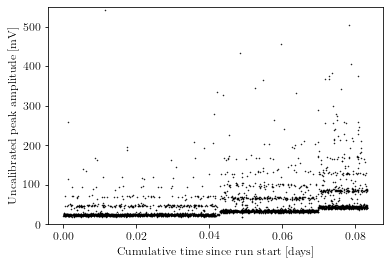

In [12]:
fig=plt.figure()
time_vec = (all_data[:,0]-np.min(all_data[:,0]))/(3600*24)
plt.plot( time_vec, all_data[:,1], 'k.', ms=1, rasterized=True )
#print(3.52*(3600*24)+all_data[0,0])
#plt.xlim((3.52,3.6))
plt.ylim((0,550))
plt.xlabel("Cumulative time since run start [days]")
plt.ylabel("Uncalibrated peak amplitude [mV]")
fig.set_size_inches(6,4)
plt.savefig("amp_vs_time_uncal.pdf")

plt.show()


In [17]:
def gauss_fun(x, A, mu, sig):
    return A * np.exp( -(x-mu)**2/(2*sig**2) )

def lin_fun(x, m, x1):
    return m*(x-x1)

def lin_fun_const(x, m):
    return lin_fun(x,m,0)

In [18]:
def fit_hist(bc,hh, numsig=4, max_peaks=5):
    
    out_vals = []
    
    spe_loc = bc[np.argmax(hh)]
    sig = spe_loc*0.05
    fpts = np.logical_and( bc >= spe_loc - numsig*sig, bc <= spe_loc + numsig*sig)
    
    bestp, covp = curve_fit(gauss_fun, bc[fpts], hh[fpts], p0=[1, spe_loc, sig])
    
    out_vals.append([1, bestp[1], np.sqrt(covp[1,1])])
    
    xx = np.linspace( spe_loc - numsig*sig, spe_loc + numsig*sig, 100 )
    plt.plot( xx, gauss_fun(xx, *bestp), 'r' )
    
    spe_loc = bestp[1]
    sig = np.abs(bestp[2])
    
    for n in range(2,max_peaks):
        
        fpts = np.logical_and( bc >= n*spe_loc - numsig*sig, bc <= n*spe_loc + numsig*sig)
        if(np.sum(fpts) == 0): 
            continue
        
        bestp, covp = curve_fit(gauss_fun, bc[fpts], hh[fpts], p0=[1, n*spe_loc, sig])
        
        out_vals.append([n, bestp[1], np.sqrt(covp[1,1])])
        
        xx = np.linspace( n*spe_loc - numsig*sig, n*spe_loc + numsig*sig, 100 )
        plt.plot( xx, gauss_fun(xx, *bestp), 'r' )
        
        sig = np.abs(bestp[2])
        
        
    return np.array(out_vals)

In [19]:
def calibrate_data(all_data, max_peaks=4):

    OV_list = np.unique(all_data[:,2])
    print(OV_list)
    
    gain_vs_ov = np.zeros((len(OV_list),2))

    for i, ov in enumerate(OV_list):
        gpts = all_data[:, 2] == ov

        hh, be = np.histogram(all_data[gpts, 1], bins=range(0,500,2))
        bc = be[:-1] + np.diff(be)/2

        plt.figure()
        plt.step(be[:-1], hh, where='post', color='k')
        plt.gca().set_yscale('log')
        yy = plt.ylim()

        gain_list = fit_hist(bc,hh, max_peaks=max_peaks)
        plt.ylim(yy)
        plt.xlim(0,500)
        
        plt.title("Gain calibration, bias voltage = %.1f"%ov)
        plt.ylabel("Counts")
        plt.xlabel("Amplitude (mV)")
        plt.savefig("gain_calib_%.1f.pdf"%ov)
        
        plt.figure()
        plt.errorbar(gain_list[:,0], gain_list[:,1], yerr=gain_list[:,2], fmt='k.')
        
        linfitp, linfitcov = curve_fit(lin_fun_const, gain_list[:,0], gain_list[:,1], sigma=gain_list[:,2])
        
        xx = np.linspace(0, np.max(gain_list[:,0]), 100)
        plt.plot(xx, lin_fun_const(xx,*linfitp), 'r', label="Gain = %.2f $\pm$ %.2f mV/PE"%(linfitp, np.sqrt(linfitcov)))
        plt.legend()
        
        gain_vs_ov[i,0] = linfitp
        gain_vs_ov[i,1] = np.sqrt(linfitcov)
    
    return gain_vs_ov, OV_list

[30. 31. 32.]


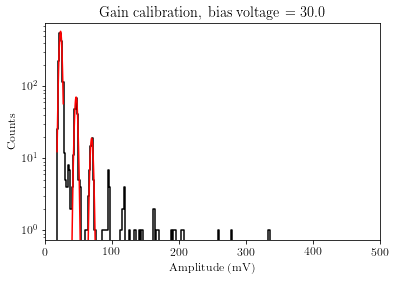

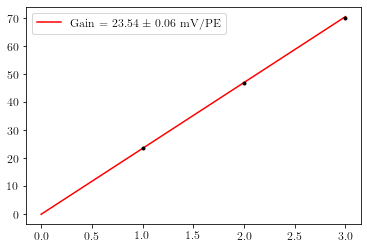

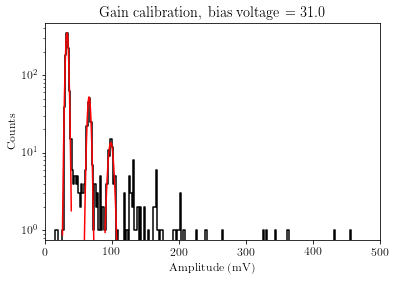

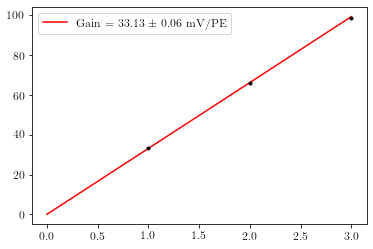

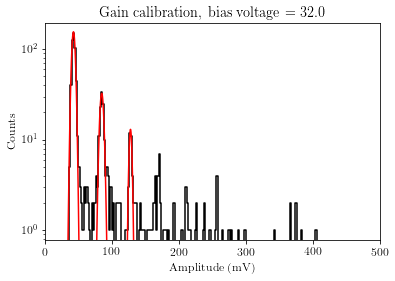

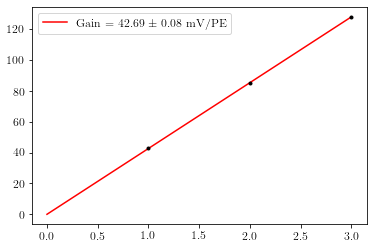

In [20]:
gain_data_all, OV_list_all = calibrate_data(all_data)
#gain_data_new, OV_list_new = calibrate_data(new_data, max_peaks=3)
plt.show()

In [24]:
def plot_gain_data(fig, OV_list, gain_vs_ov, dc='k', lc='r'):

    plt.figure(fig.number)
    plt.errorbar(OV_list, gain_vs_ov[:,0], yerr=gain_vs_ov[:,1], fmt=dc+'.')

    linfitp, linfitcov = curve_fit(lin_fun, OV_list, gain_vs_ov[:,0], sigma=gain_vs_ov[:,1])
    linfiterr = np.sqrt(linfitcov[1,1])
    xx = np.linspace(27, np.max(OV_list), 100 )
    plt.plot( xx, lin_fun(xx, *linfitp), lc, label=r"$V_{bd} = %.2f \pm %.2f$"%(linfitp[1], linfiterr))
    plt.plot(xx, np.zeros_like(xx), 'k:')
    


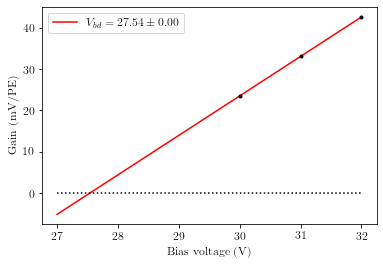

In [25]:
fig=plt.figure()
plot_gain_data(fig, OV_list_all, gain_data_all)
#plot_gain_data(fig, OV_list_new, gain_data_new, dc='k', lc='c')
plt.ylabel("Gain (mV/PE)")
plt.xlabel("Bias voltage (V)")

plt.legend()
plt.savefig("gain_extrap.pdf")


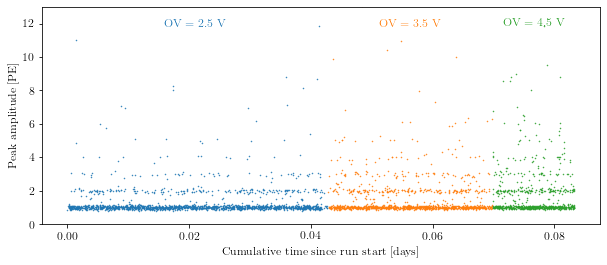

In [26]:
## now calibrate the rate plot in PE
Vbd = 27.5

timevec = (all_data[:,0]-np.min(all_data[:,0]))/(3600*24)
amp_data_mV = all_data[:,1]
amp_data_PE = np.zeros_like(amp_data_mV)

for ov in OV_list_all:
    gpts = all_data[:,2] == ov
    curr_gain = gain_data_all[OV_list_all == ov,0][0]
    amp_data_PE[gpts] = amp_data_mV[gpts]/curr_gain
    
fig=plt.figure()
for ov in OV_list_all:
    gpts = np.logical_and(amp_data_PE > 0.8, all_data[:,2] == ov)
    p=plt.plot( time_vec[gpts], amp_data_PE[gpts], '.', ms=1, rasterized=True )
    col=p[0].get_color()
    plt.text(np.mean(time_vec[gpts]), 12, "OV = %.1f V"%(ov-Vbd), va='center', ha='center', color=col, weight='bold')
plt.xlabel("Cumulative time since run start [days]")
plt.ylabel("Peak amplitude [PE]")
plt.ylim([0,13])
fig.set_size_inches(10,4)
plt.savefig("amp_vs_time_cal.pdf")

<Figure size 432x288 with 0 Axes>

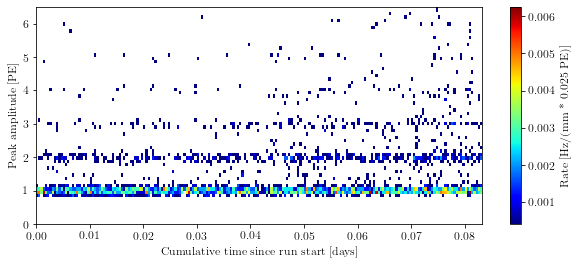

In [27]:
fig=plt.figure()

## now a 2d histogram
gpts = amp_data_PE > 0.8

hh, xedges, yedges = np.histogram2d( time_vec[gpts], amp_data_PE[gpts], bins=(200,400) )

tot_time = (433+228+226+225+222)*100*0.1
nbins = 200
time_per_bin = tot_time/nbins
mm2 = 36
conv_fac = 1/(time_per_bin * mm2)

hh[hh == 0] = np.nan
fig=plt.figure()
plt.pcolormesh( xedges, yedges, hh.T * conv_fac, cmap='jet', rasterized=True)
plt.ylim(0,6.5)
plt.colorbar(label="Rate [Hz/(mm * 0.025 PE)]")
plt.xlabel("Cumulative time since run start [days]")
plt.ylabel("Peak amplitude [PE]")
fig.set_size_inches(10,4)
plt.savefig("amp_vs_time_histo.pdf")

In [28]:
## now 1d rate plot

gpts = amp_data_PE > 0.8
hh, be = np.histogram( time_vec[gpts], bins=500 )
bc = be[:-1] + np.diff(be)/2

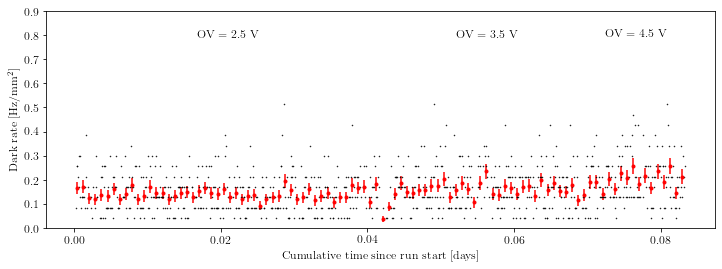

In [31]:
## now 1d rate plot

fig=plt.figure()

gpts = amp_data_PE > 0.8

total_number_of_files = 65

tot_time = total_number_of_files*100*0.1
nbins = 1000
time_per_bin = tot_time/nbins
mm2 = 36
conv_fac = 1/(time_per_bin * mm2)

hh, be = np.histogram( time_vec[gpts], bins=nbins )
bc = be[:-1] + np.diff(be)/2

gpts = hh > 0
gpts = np.logical_and( np.roll(hh, -1) > 0, gpts)
gpts = np.logical_and( np.roll(hh, 1) > 0, gpts)

plt.errorbar( bc[gpts], hh[gpts]*conv_fac, yerr=0*np.sqrt(hh[gpts])*conv_fac, fmt='k.', lw=0.5, ms=1, rasterized=True)

nbins = 100
time_per_bin = tot_time/nbins
mm2 = 36
conv_fac = 1/(time_per_bin * mm2)

gpts = amp_data_PE > 0.8
hh, be = np.histogram( time_vec[gpts], bins=nbins )
bc = be[:-1] + np.diff(be)/2

gpts = hh > 0
gpts = np.logical_and( np.roll(hh, -1) > 0, gpts)
gpts = np.logical_and( np.roll(hh, 1) > 0, gpts)

plt.errorbar( bc[gpts], hh[gpts]*conv_fac, yerr=np.sqrt(hh[gpts])*conv_fac, fmt='r.')

for ov in OV_list_all:
    gpts = np.logical_and(amp_data_PE > 0.8, all_data[:,2] == ov)

    plt.text(np.mean(time_vec[gpts]), 0.8, "OV = %.1f V"%(ov-Vbd), va='center', ha='center', color='k', weight='bold')

plt.xlabel("Cumulative time since run start [days]")
plt.ylabel("Dark rate [Hz/mm$^2$]")
plt.ylim([0,0.9])

fig.set_size_inches(12,4)
plt.savefig("rate_vs_time.pdf")